In [ ]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scikitplot as skp
from sklearn.linear_model import LogisticRegression
from neuralgam import FullyConnectNeuralGam 
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.dummy import DummyClassifier
from keras.optimizers import Adam, SGD
from machinedesign.viz import grid_of_images_default
from skimage.io import imsave
from itertools import combinations
from IPython.display import Image
from sklearn.utils import shuffle
from lightjob.cli import load_db
import sys
sys.path.append('..')
from hypers import get_df

def show_several(df):
    for j in df.index:
        print(j)
        show_one(j)

def show_one(j):
    X = np.load('../results/jobs/{}/gen/generated.npz'.format(j))['generated'][0:100]
    X = grid_of_images_default(X, border=10, bordercolor=(0,0,0))
    imsave('out.png', X)
    im = Image('out.png')
    display(im)

In [2]:
labels = pd.read_csv('export_data.csv')
hypers = get_df()
hypers['innovative'] = np.nan
hypers['existing'] = np.nan
hypers['noisy'] = np.nan
for i in range(len(labels)):
    l = labels.iloc[i]
    if l['id'] in hypers.index:
        hypers.loc[l['id'], l['label']] = 1
hypers_full = hypers
hypers = hypers.dropna(axis=0, how='all', subset=['innovative', 'existing', 'noisy'])

#hypers.loc[:, 'innovative'] = hypers['innovative'].astype(int)
#hypers.loc[:, 'existing'] = hypers['existing'].astype(int)
#hypers.loc[:, 'noisy'] = hypers['noisy'].astype(int)
hypers = shuffle(hypers, random_state=42) 
inp_cols = ['letters_count', 
            'letters_diversity', 
            'letters_object', 
              #'letters_objectness',
              #'digits_and_letters_objectness',
              #'emnist_objectness',
              #'emnist_object',
              #'emnist_letters_count',
              #'letters_diversity',
              #'emnist_letters_diversity',
              #'hwrt_objectness',
              #'zero_ratio',
              #'bottleneck',
              #'noise',
              #'stride',
              #'nb_params'
]
inp = hypers[inp_cols]
inp = inp.fillna(-1)
#out = hypers[['innovative', 'existing', 'noisy']]
out = hypers['innovative']
#out = hypers['existing']
#out = hypers['noisy']
out = out.fillna(0)
X = inp.values
#X_mu = X.mean(axis=0, keepdims=True)
#X_std = X.std(axis=0, keepdims=True)
#X = (X - X_mu) / X_std
y = out.values
colnames = inp.columns

In [10]:
#model = LogisticRegression()
#model = LogisticRegression(C=1.0, penalty='l1')
#model = MLPClassifier(hidden_layer_sizes=[500, 250], alpha=0.001, max_iter=300, batch_size=32)
model = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=42)
#model = DummyClassifier(strategy='most_frequent')
#scores = cross_val_score(model, inp, out, scoring='accuracy')
#print(np.mean(scores), np.std(scores))
model.fit(X, y)
if isinstance(model, LogisticRegression):
    model.feature_importances_ = (model.coef_[0])**2 / ((model.coef_[0])**2).sum()
if isinstance(model, RandomForestClassifier):
    print('OOB score : {}'.format(model.oob_score_))
ypred = model.predict(X)
print((ypred ==y).mean())

OOB score : 0.8555555555555555
1.0


In [4]:
np.random.seed(42)
features = []
orders = [1]
F = np.arange(X.shape[1])
for o in orders:
    for f in combinations(F, o):
        features.append(f)
names = [str(tuple([colnames[i] for i in f])) for f in features]
model = FullyConnectNeuralGam(
    hidden_units=[200, 120],
    hidden_activation='relu',
    output_activation='linear',
    features=features,
    optimizer=Adam(lr=0.01),
    loss='mean_squared_error',
    batch_size=32,
    epochs=100,
    verbose=0
)
model.fit(X, y)
ypred = model.predict(X)>=0.5
ypred = ypred[:, 0]
print((ypred==y).mean())
ylist = model.predict_components(X)
yl = np.concatenate(ylist, axis=1)
model.feature_importances_ = yl.var(axis=0) / yl.var(axis=0).sum()

0.866666666667


('letters_count',)


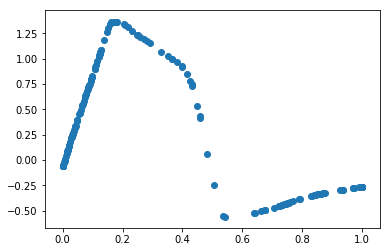

('letters_diversity',)


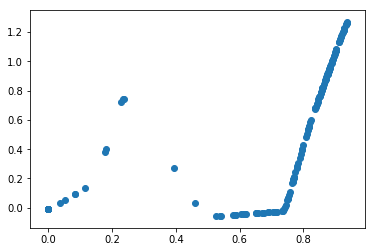

('letters_object',)


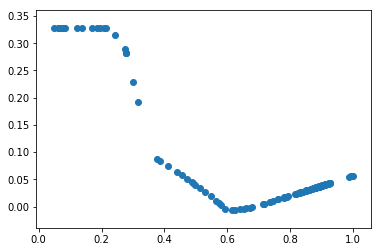

In [5]:
x = X.copy()
ylist = model.predict_components(X)
for i in range(len(features)):
    print(names[i])
    plt.scatter(x[:, features[i][0]], ylist[i])
    plt.show()

In [ ]:
skp.plotters.plot_feature_importances(model,figsize=(30, 4), feature_names=names)
plt.show()

4a4b3a3a4562d7102aceb49eab12c8c0


/home/mcherti/miniconda/envs/py3/lib/python3.5/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


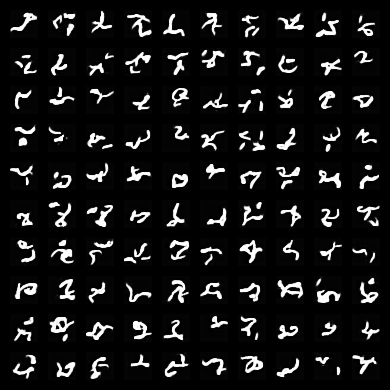

901dad8ec11f23191d86fa6279d47c65


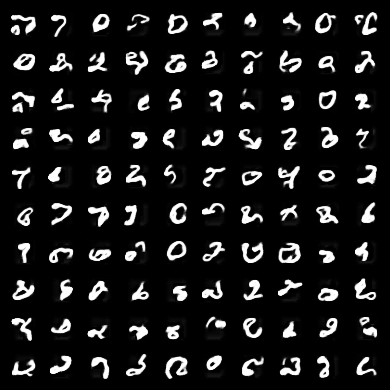

cc68a4a318fc51e325ec4b74e1563812


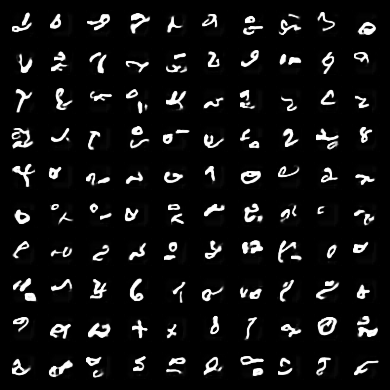

a167259933f54183c717cd4ed0529081


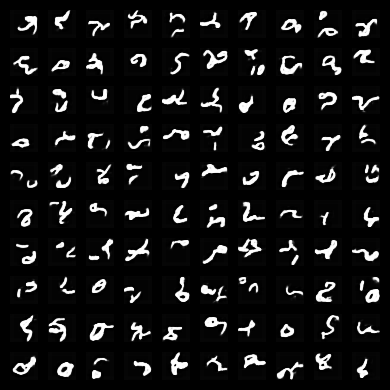

68adffea6c98fedf329644122d56fa36


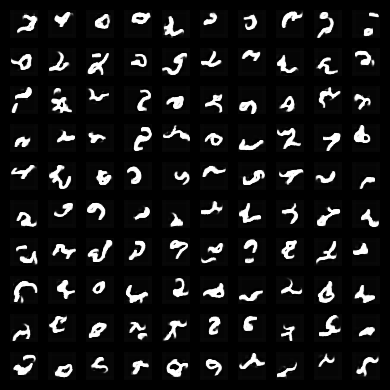

In [11]:
H = hypers_full.copy()
Xfull = H[inp_cols].fillna(-1).values
if hasattr(model, 'predict_proba'):
    ypred = model.predict_proba(Xfull)
    ypred = ypred[:, 1]
else:
    ypred = model.predict(Xfull)
ypred = ypred.flatten()
H['y'] = ypred
H.to_csv('hypers.csv', index_label='job_id')
h = H.sort_values(by='y', ascending=False)
show_several(h.iloc[0:5])